In [7]:
# Cell 1: Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

# Add the 'src' folder to the path
sys.path.insert(0, os.path.abspath('../src'))

# --- Import our tools ---
from data_fetcher.yfinance_fetcher import fetch_data
from calibration.ou_calibrator import OuCalibrator
from models.ou import OrnsteinUhlenbeck
from analysis.stationarity import check_stationarity_adf

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
print("All modules imported successfully.")

All modules imported successfully.


Fetching ^INDIAVIX data from 2021-01-01 to 2024-12-31...


/media/harsh-vardhan-gupta/New Volume/Placement Prep/BTP/src/data_fetcher/yfinance_fetcher.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

--- Running Augmented Dickey-Fuller (ADF) Test ---
ADF Statistic: -3.2050
p-value: 0.0197

Critical Values:
   1%: -3.4371
   5%: -2.8645
   10%: -2.5684

Conclusion: The data is STATIONARY (p < 0.05).
It is suitable for the Ornstein-Uhlenbeck model.
Data fetched successfully. 973 data points.


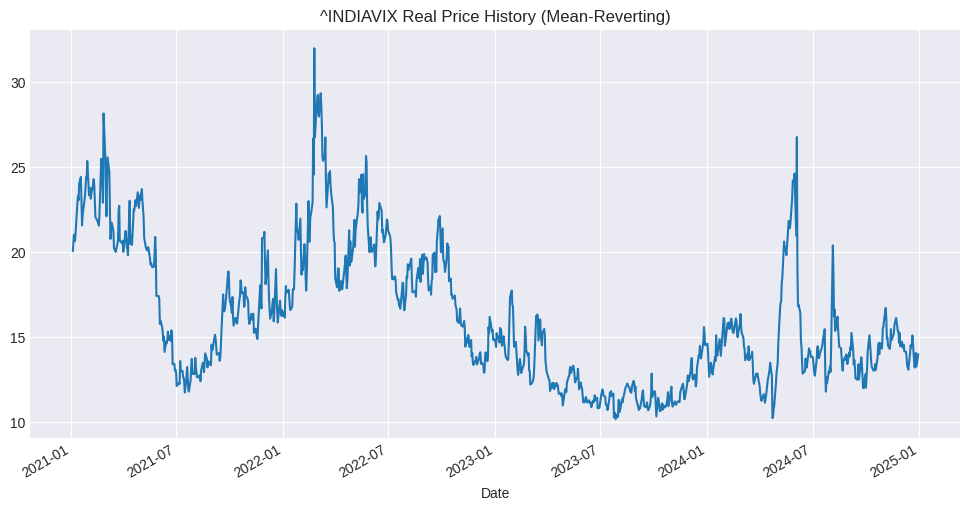

--- Calibrating Ornstein-Uhlenbeck (OU) Model ---
OU Calibrated Params: {'theta': np.float64(7.383660866678376), 'mu': np.float64(15.880849519776097), 'sigma': np.float64(15.29662713232002), 'X0': np.float64(20.030000686645508)}

Log-Likelihood: -1343.16
AIC: 2692.33
BIC: 2706.97


In [8]:
# Cell 2: Fetch Real D# Cell 2: Fetch Real Data (VIX)
ticker = '^INDIAVIX' # The CBOE Volatility Index
start = '2021-01-01'
end = '2024-12-31' 

print(f"Fetching {ticker} data from {start} to {end}...")
vix_data = fetch_data(ticker, start, end)[ticker]

is_stationary = check_stationarity_adf(vix_data)

assert vix_data is not None, "Data fetching failed!"

print(f"Data fetched successfully. {len(vix_data)} data points.")
vix_data.plot(title=f"{ticker} Real Price History (Mean-Reverting)", figsize=(12, 6))
plt.show()

# Cell 3: Calibrate the OU Model
print("--- Calibrating Ornstein-Uhlenbeck (OU) Model ---")

# Create the calibrator
ou_cal = OuCalibrator(dt=1/252)

# Fit the model to the VIX data
ou_cal.fit(vix_data)

calibrated_params_ou = ou_cal.get_params()

print(f"OU Calibrated Params: {calibrated_params_ou}")
print(f"\nLog-Likelihood: {ou_cal.get_log_likelihood():.2f}")
print(f"AIC: {ou_cal.get_aic():.2f}")
print(f"BIC: {ou_cal.get_bic():.2f}")


--- Plotting Calibrated Simulations ---


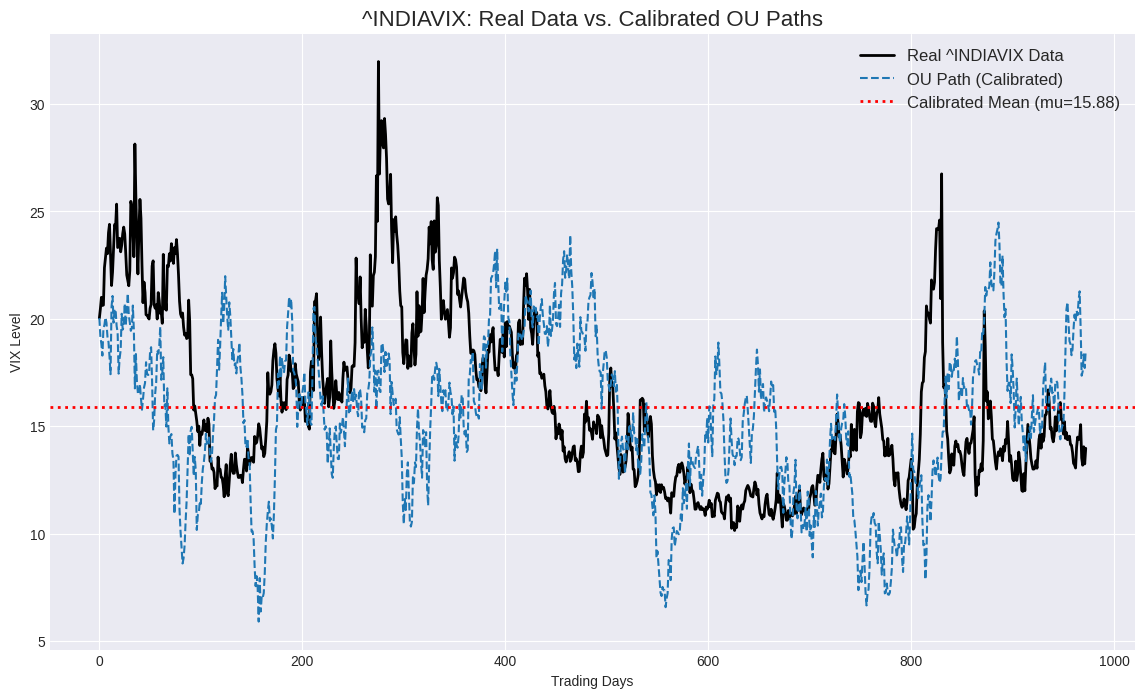

In [9]:
# Cell 4: Validate - Plot Simulated vs. Real
print("\n--- Plotting Calibrated Simulations ---")

# 1. Instantiate the OU model with the *real* params
ou_model_calibrated = OrnsteinUhlenbeck(**calibrated_params_ou)

# 2. Set simulation time
T = (ou_cal.n_obs) * ou_cal.dt
dt = ou_cal.dt
n_paths_to_plot = 1

# 3. Run new simulations
paths_ou = ou_model_calibrated.simulate(T, dt, n_paths_to_plot)

# 4. Plot everything
plt.figure(figsize=(14, 8))

# Plot the real data
real_data_plot = vix_data.reset_index(drop=True)
plt.plot(real_data_plot, color='black', linewidth=2.0, label=f"Real {ticker} Data")

# Plot the simulated paths
plt.plot(paths_ou, linestyle='--', linewidth=1.5, label="OU Path (Calibrated)")

# Plot the calibrated mean
plt.axhline(
    calibrated_params_ou['mu'], 
    color='red', 
    linestyle=':', 
    linewidth=2.0, 
    label=f"Calibrated Mean (mu={calibrated_params_ou['mu']:.2f})"
)

plt.title(f"{ticker}: Real Data vs. Calibrated OU Paths", fontsize=16)
plt.xlabel("Trading Days")
plt.ylabel("VIX Level")

# Clean up the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=12)

plt.show()